# *【Project】* Logistic Regression - Heart Disease

World Health Organization has estimated 12 million deaths occur worldwide, every year due to Heart diseases. Half the deaths in the United States and other developed countries are due to cardio vascular diseases. The early prognosis of cardiovascular diseases can aid in making decisions on lifestyle changes in high risk patients and in turn reduce the complications. This research intends to pinpoint the most relevant/risk factors of heart disease as well as predict the overall risk using logistic regression.

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab

## 1. Data Preparation
#### Source:
The dataset is publically available on the Kaggle website, and it is from an ongoing ongoing cardiovascular study on residents of the town of Framingham, Massachusetts. The classification goal is to **predict whether the patient has 10-year risk of future coronary heart disease (CHD).** The dataset provides the patients’ information. It includes over 4,000 records and 15 attributes.

In [3]:
heart_df = pd.read_csv('framingham.csv')
heart_df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [5]:
heart_df.drop(['education'], axis=1, inplace=True)
heart_df.rename(columns={'male':'Gender_male'}, inplace=True)

#### Variables :
Each attribute is a potential risk factor. There are both demographic, behavioural and medical risk factors.

* Demographic: 
    * sex: male or female;(Nominal)

    * age: age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous)
* Behavioural:

    * currentSmoker: whether or not the patient is a current smoker (Nominal)

    * cigsPerDay: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarretts, even half a cigarette.)

* Medical( history):

    * BPMeds: whether or not the patient was on blood pressure medication (Nominal)

    * prevalentStroke: whether or not the patient had previously had a stroke (Nominal)

    * prevalentHyp: whether or not the patient was hypertensive (Nominal)

    * diabetes: whether or not the patient had diabetes (Nominal)

* Medical(current):

    * totChol: total cholesterol level (Continuous)

    * sysBP: systolic blood pressure (Continuous)

    * diaBP: diastolic blood pressure (Continuous)

    * BMI: Body Mass Index (Continuous)

    * heartRate: heart rate (Continuous - In medical research, variables such as heart rate though in fact discrete, yet are considered continuous because of large number of possible values.)

    * glucose: glucose level (Continuous)
    

* **Predict variable (desired target):**

    * 10 year risk of coronary heart disease CHD (binary: “1”, means “Yes”, “0” means “No”)

### Missing values

In [9]:
heart_df.isnull().mean()*100

Gender_male        0.000000
age                0.000000
currentSmoker      0.000000
cigsPerDay         0.683962
BPMeds             1.250000
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            1.179245
sysBP              0.000000
diaBP              0.000000
BMI                0.448113
heartRate          0.023585
glucose            9.150943
TenYearCHD         0.000000
dtype: float64

In [12]:
# Total number of rows with missing values
(heart_df.isnull().sum(axis=1) > 0).sum()

489

In [14]:
100* 489/heart_df.shape[0]

11.533018867924529

Total number of rows with missing values is  489
since it is only 12 percent of the entire dataset the rows with missing values are excluded.

In [15]:
heart_df.dropna(axis=0, inplace=True)

## 2. Exploratory Analysis

<Figure size 432x288 with 0 Axes>

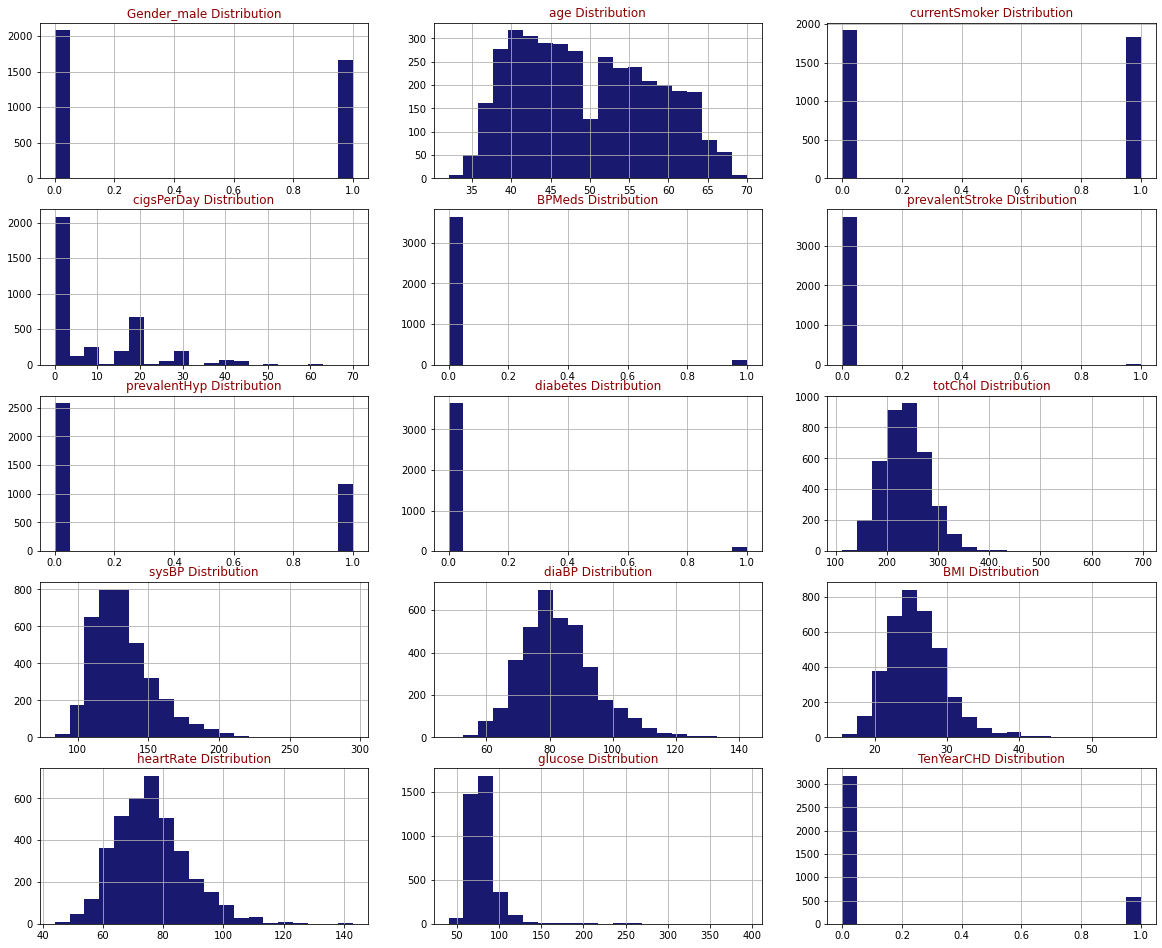

In [26]:
def draw_histograms(dataframe, features, rows, cols):
    fig = plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        dataframe[feature].hist(bins=20, ax=ax, facecolor='midnightblue')
        ax.set_title(feature+" Distribution", color='DarkRed')

plt.tight_layout()
plt.show()
draw_histograms(heart_df, heart_df.columns,6,3)

In [27]:
heart_df.TenYearCHD.value_counts()

0    3179
1     572
Name: TenYearCHD, dtype: int64

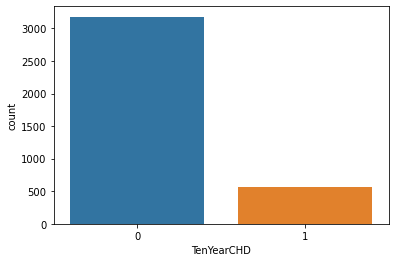

In [28]:
sn.countplot(x='TenYearCHD', data=heart_df);

There are 3179 patents with no heart disease and 572 patients with risk of heart disease.

In [29]:
heart_df.describe()

,Gender_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000,3751.000000
mean,0.445215,49.573447,0.488403,9.008531,0.030392,0.005599,0.311917,0.027193,236.928019,132.368435,82.938550,25.808288,75.704079,81.880032,0.152493
std,0.497056,8.570204,0.499932,11.925097,0.171686,0.074623,0.463338,0.162666,44.611594,22.046522,11.932779,4.065599,11.956382,23.882233,0.359546
min,0.000000,32.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.085000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.410000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.060000,82.000000,87.000000,0.000000
max,1.000000,70.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


## 3. Splitting data to train and test split, modelling

In [30]:
import sklearn
new_features = heart_df[['age','Gender_male','cigsPerDay','totChol','sysBP','glucose','TenYearCHD']]
x = new_features.iloc[:,:-1]
y = new_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.20, random_state=5)

In [32]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [33]:
y_pred = logreg.predict(x_test)

## 4. Model evolution 
### Accuracy

In [34]:
sklearn.metrics.accuracy_score(y_test, y_pred)

0.8748335552596538

### Confusion matrix

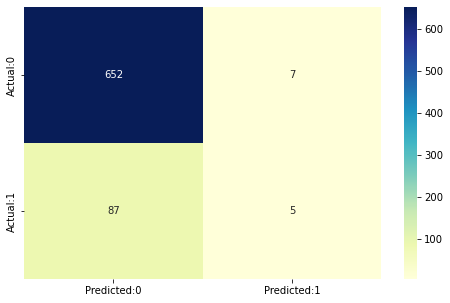

In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix = pd.DataFrame(data=cm, columns=['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sn.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu");

The confusion matrix shows 652+5 = 657 correct predictions and 87+7= 94 incorrect ones.

* True Positives: 5
* True Negatives: 652
* False Positives: 7 (Type I error)
* False Negatives: 87 ( Type II error)

In [36]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [38]:
print('The acuuracy of the model = (TP+TN)/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n',

'The Missclassification = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n',

'Sensitivity or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n',

'Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = (TP+TN)/(TP+TN+FP+FN) =  0.8748335552596538 
 The Missclassification = 1-Accuracy =  0.12516644474034622 
 Sensitivity or True Positive Rate = TP/(TP+FN) =  0.05434782608695652 
 Specificity or True Negative Rate = TN/(TN+FP) =  0.9893778452200304 
 Positive Predictive value = TP/(TP+FP) =  0.4166666666666667 
 Negative predictive Value = TN/(TN+FN) =  0.8822733423545331 
 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  5.116459627329198 
 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.9558048813016804


**From the above statistics it is clear that the model is highly specific than sensitive. The negative values are predicted more accurately than the positives.**

#### Predicted probabilities of 0 (No Coronary Heart Disease) and 1 ( Coronary Heart Disease: Yes) for the test data with a default classification threshold of 0.5

In [39]:
y_pred_prob=logreg.predict_proba(x_test)[:,:]
y_pred_prob_df=pd.DataFrame(data=y_pred_prob, columns=['Prob of no heart disease (0)','Prob of Heart Disease (1)'])
y_pred_prob_df.head()

,Prob of no heart disease (0),Prob of Heart Disease (1)
0,0.874999,0.125001
1,0.956170,0.043830
2,0.783498,0.216502
3,0.806609,0.193391
4,0.892850,0.107150


### Lower the threshold
Since the model is predicting Heart disease too many type II errors is not advisable. A False Negative ( ignoring the probability of disease when there actualy is one) is more dangerous than a False Positive in this case. Hence inorder to increase the sensitivity, threshold can be lowered.

In [40]:
from sklearn.preprocessing import binarize
for i in range(1, 5):
    cm2 = 0
    y_pred_prob_yes = logreg.predict_proba(x_test)
    y_pred2 = binarize(y_pred_prob_yes, threshold=i/10)[:,1]
    cm2 = confusion_matrix(y_test, y_pred2)
    print('With', i/10, 'threshold the Confusion Matrix is ', '\n', cm2, '\n',
    'with', cm2[0,0]+cm2[1,1], 'correct predictions and', cm2[1,0], 'Type II errors( False Negatives)', '\n\n',
    'Sensitivity: ', cm2[1,1]/(float(cm2[1,1]+cm2[1,0])), 'Specificity: ', cm2[0,0]/(float(cm2[0,0]+cm2[0,1])), '\n\n\n')

With 0.1 threshold the Confusion Matrix is  
 [[311 348]
 [ 12  80]] 
 with 391 correct predictions and 12 Type II errors( False Negatives) 

 Sensitivity:  0.8695652173913043 Specificity:  0.47192716236722304 



With 0.2 threshold the Confusion Matrix is  
 [[518 141]
 [ 43  49]] 
 with 567 correct predictions and 43 Type II errors( False Negatives) 

 Sensitivity:  0.532608695652174 Specificity:  0.7860394537177542 



With 0.3 threshold the Confusion Matrix is  
 [[600  59]
 [ 64  28]] 
 with 628 correct predictions and 64 Type II errors( False Negatives) 

 Sensitivity:  0.30434782608695654 Specificity:  0.9104704097116844 



With 0.4 threshold the Confusion Matrix is  
 [[640  19]
 [ 80  12]] 
 with 652 correct predictions and 80 Type II errors( False Negatives) 

 Sensitivity:  0.13043478260869565 Specificity:  0.9711684370257967 





### ROC curve

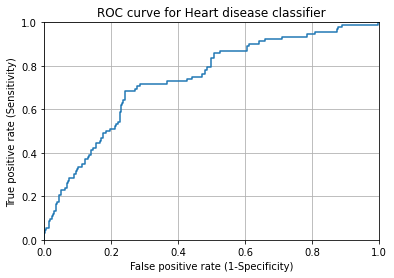

In [41]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_yes[:,1])
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')
plt.grid(True)

A common way to visualize the trade-offs of different thresholds is by using an ROC curve, a plot of the true positive rate (# true positives/ total # positives) versus the false positive rate (# false positives / total # negatives) for all possible choices of thresholds. A model with good classification accuracy should have significantly more true positives than false positives at all thresholds.

The optimum position for roc curve is towards the top left corner where the specificity and sensitivity are at optimum levels

### Area Under The Curve (AUC)

The area under the ROC curve quantifies model classification accuracy; the higher the area, the greater the disparity between true and false positives, and the stronger the model in classifying members of the training dataset. An area of 0.5 corresponds to a model that performs no better than random classification and a good classifier stays as far away from that as possible. An area of 1 is ideal. The closer the AUC to 1 the better.

In [42]:
sklearn.metrics.roc_auc_score(y_test,y_pred_prob_yes[:,1])

0.7385696377911195

## Conclusions:

* All attributes selected after the elimination process show P-values lower than 5% and thereby suggesting significant role in the Heart disease prediction.


* Men seem to be more susceptible to heart disease than women.Increase in Age, number of cigarettes smoked per day and systolic Blood Pressure also show increasing odds of having heart disease.


* Total cholesterol shows no significant change in the odds of CHD. This could be due to the presence of good cholesterol(HDL) in the total cholesterol reading. Glucose too causes a very negligible change in odds (0.2%)


* The model predicted with 0.88 accuracy. The model is more specific than sensitive.


* The Area under the ROC curve is 73.5 which is somewhat satisfactory.


* Overall model could be improved with more data.